# THE CHALLENGE

The problem we will be looking at is an image classification task on X-ray scans of the human body.

In this example, we focus on images of the spine which are frequently used during the planning of surgical procedures. 

An automated analysis of such images is thus an important feature.

The first step in such a process is to detect in which direction the X-ray was taken. Roughly speaking, there are two ways:

1. The X-rays traverse the body from front to back (or back to front). We call such images AP (stands for „anteroposterior”).

2. The X-rays traverse the body from left to right (or right to left). We call such images lateral.




In [545]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [546]:
import sys

import os 
from os import makedirs
from os import listdir

import shutil
from shutil import copyfile

import random
from random import seed

import seaborn as sns

from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.pyplot as plt

#from PIL import Image
#from resizeimage import resizeimage
import cv2

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load
from numpy.random import seed
seed(42)

from scipy import ndarray

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from keras.layers import BatchNormalization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# image processing library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io



# Data Exploration

- show train and test set size
- plot some images



In [547]:
# parameters

# define location of dataset
train_folder = '../SnkeOS_MLENgineer_ChallengeData/Train/'
test_folder = '../SnkeOS_MLENgineer_ChallengeData/Test/'

train_image_file = 'train_images.npy'
train_label_file = 'train_labels.npy'

test_image_file = 'test_images.npy'
test_label_file = 'test_labels.npy'

img_size = (256, 256)

lateral_label = 'Lateral'
ap_label = 'AP'


In [548]:
# functions

def get_img_files(folder, 
                  lateral_label='Lateral', 
                  ap_label='AP',
                 #images_file,
                 #labels_file,
                 #img_size=(256, 256),
                ):
    lateral_files = []
    ap_files = []
    files = []
    
    #labels = list()
    #images = list()
    for file_name in os.listdir(folder):
        label = ''
        if lateral_label in file_name:
            lateral_files.append(folder + file_name)
            label = 'Lateral'
        if ap_label in file_name:
            ap_files.append(folder + file_name)
            label = 'AP'
            
        #files.append(folder + file_name)
        #labels.append(label)
        # load image
        #image = load_img(folder + file_name, target_size=img_size)
        # convert to numpy array
        #image = img_to_array(image)
        #images.append(image)

    # convert to a numpy arrays
    #images = asarray(images)
    #labels = asarray(labels)
    #print(images.shape, labels.shape)

    # save the images
    #save(images_file, images)
    #save(labels_file, labels)
    
    return lateral_files, ap_files
    
    

In [549]:
# get train files

train_lateral_files, train_ap_files = get_img_files(folder=train_folder)

print('number of train lateral images', len(train_lateral_files))
print('number of test ap images', len(train_ap_files))


number of train lateral images 83
number of test ap images 107


In [550]:
# get test files

test_lateral_files, test_ap_files = get_img_files(folder=test_folder)                                                                           

print('number of test lateral images', len(test_lateral_files))
print('number of test ap images', len(test_ap_files))


number of test lateral images 13
number of test ap images 14


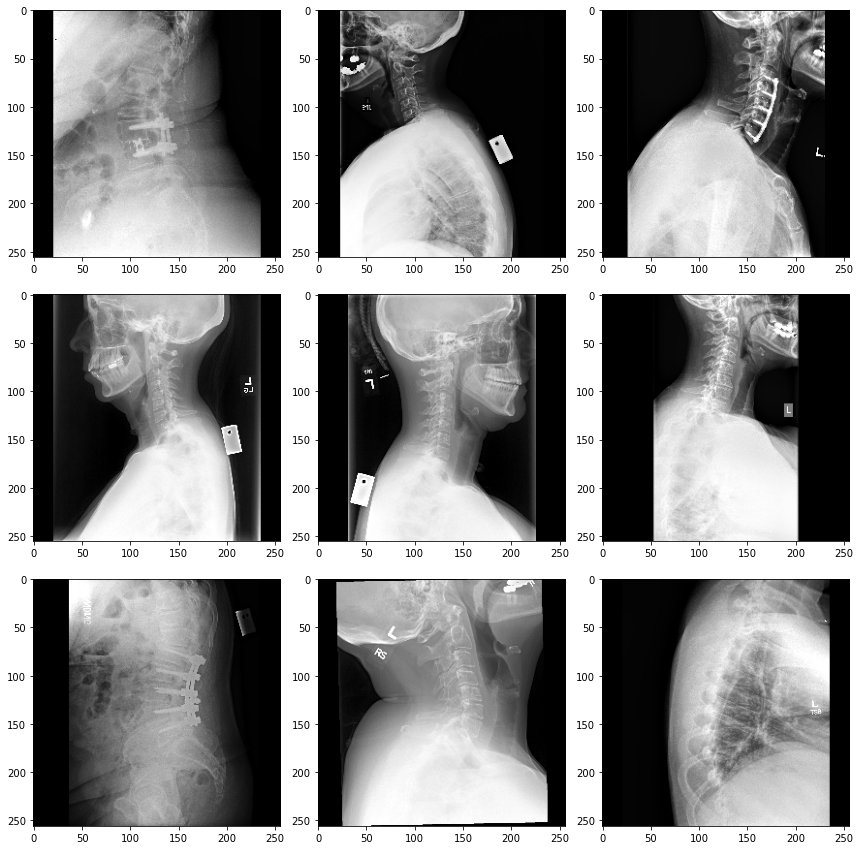

In [551]:
# plot some train images of class lateral
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample = random.choice(train_lateral_files)
    image = load_img(sample)
    plt.imshow(image)

plt.tight_layout()
plt.show()
        


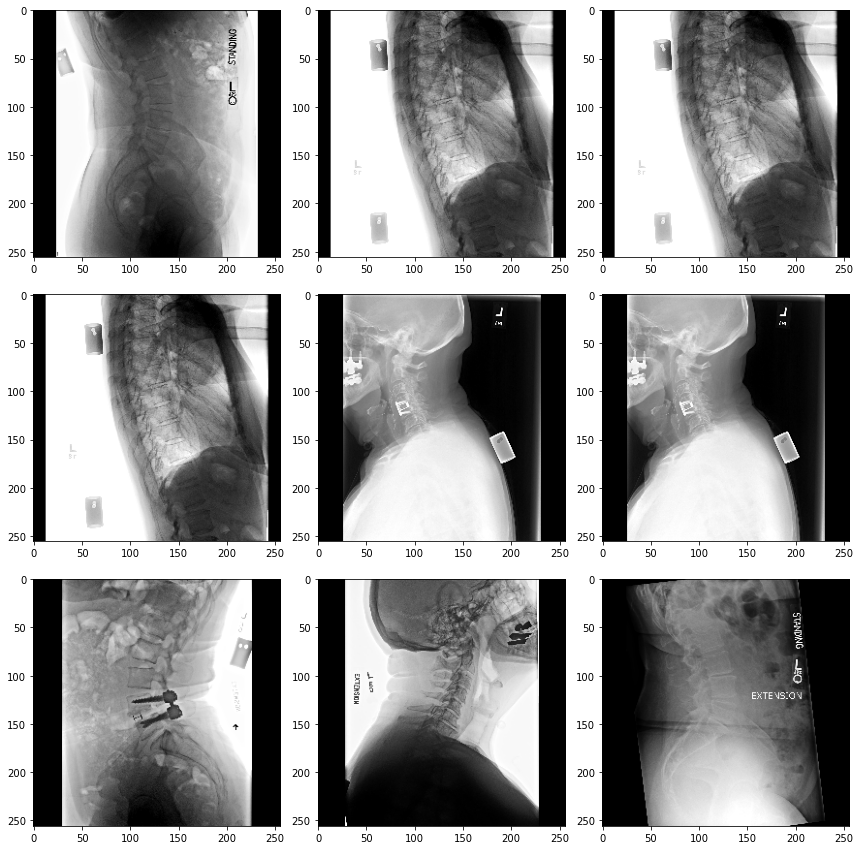

In [552]:
# plot some test images of class lateral
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample = random.choice(test_lateral_files)
    image = load_img(sample)
    plt.imshow(image)

plt.tight_layout()
plt.show()
    

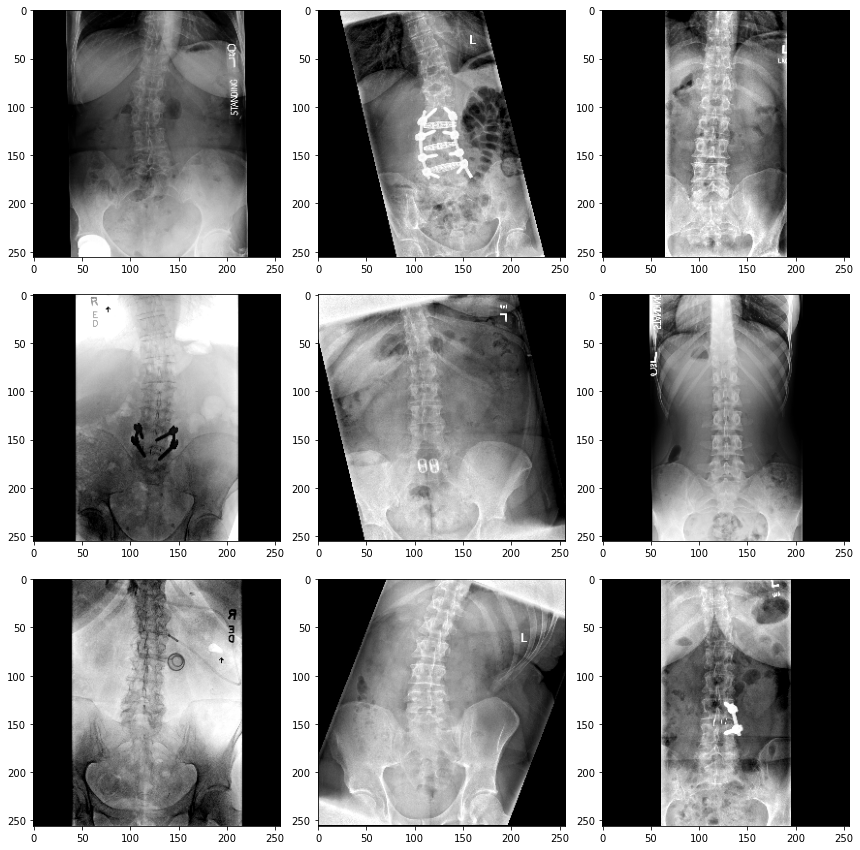

In [553]:
# plot some train images of class AP

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample = random.choice(train_ap_files)
    image = load_img(sample)
    plt.imshow(image)

plt.tight_layout()
plt.show()
    

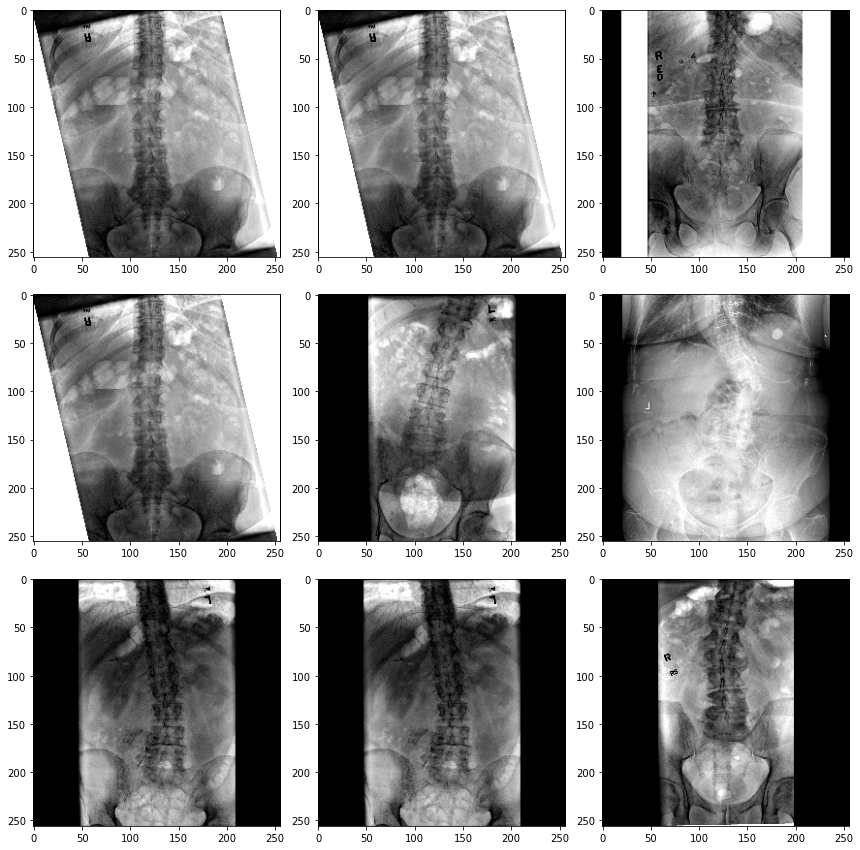

In [554]:
# plot some test images of class AP

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample = random.choice(test_ap_files)
    image = load_img(sample)
    plt.imshow(image)

plt.tight_layout()
plt.show()


# Prepare Train, Validation, and Test Sets

- randomly select 20% images from the train images as validation set
- save the train, validation, and test images into folders
- due to limited computing resources, images are resized


In [555]:
# parameters

dataset_home = 'lateral_vs_ap/'
subdirs = ['train/', 'test/', 'valid/', 'final_train/']
final_train_dir = dataset_home + subdirs[-1]

resize_img = (100, 100)
#resize_img = (128, 128)
#resize_img = None

# 20% of train images are used as validation images
val_ratio = 0.2

total_train = 190
total_valid = int(total_train * 0.2)
total_test = 27

total_train_ap = 107
total_train_lateral = 83


In [556]:
# functions

# create directories
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['lateral/', 'ap/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        if os.path.exists(newdir):
            shutil.rmtree(newdir)
        makedirs(newdir, exist_ok=False)

        
# copy training and testing dataset images into subdirectories
def save_images(src_directory, dataset_home, dst_dir_input, resize_img, val_ratio=0):
    
    if os.path.exists(dataset_home + dst_dir_input + 'ap/'):
        shutil.rmtree(dataset_home + dst_dir_input + 'ap/')
    makedirs(dataset_home + dst_dir_input + 'ap/', exist_ok=False)
    if os.path.exists(dataset_home + dst_dir_input + 'lateral/'):
        shutil.rmtree(dataset_home + dst_dir_input + 'lateral/')
    makedirs(dataset_home + dst_dir_input + 'lateral/', exist_ok=False)
    
    for file in listdir(src_directory):
        src = src_directory + '/' + file
        
        dst_dir = dst_dir_input
        if val_ratio and random.random() < val_ratio:
            dst_dir = 'valid/'
        
        dst = ''
        if 'Lateral' in file:
            dst = dataset_home + dst_dir + 'lateral/'  + file
            copyfile(src, dst)
        elif 'AP' in file:
            dst = dataset_home + dst_dir + 'ap/'  + file
            copyfile(src, dst)
        
        # resize image
        if dst and resize_img:
            src = cv2.imread(dst, cv2.IMREAD_UNCHANGED)
            output = cv2.resize(src, resize_img)
            cv2.imwrite(dst, output)
            #with open(dst, 'r+b') as f:
            #    with Image.open(f) as image:
            #        cover = resizeimage.resize_cover(image, resize_img)
            #        cover.save(dst, image.format)
        
    return



In [557]:
# create train and validation set
save_images(train_folder, dataset_home, 'train/', resize_img, val_ratio)

# create test set
save_images(test_folder, dataset_home, 'test/', resize_img)

# create final train set
save_images(train_folder, dataset_home, 'final_train/', resize_img)



# Model Creation


## Baseline CNN model

- develop a baseline convolutional neural network model based on the VGG models
https://arxiv.org/abs/1409.1556


    - stacking convolutional layers with small 3×3 filters followed by a max pooling layer. 
    - these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. 
    - padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.
    - each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.
    - the model will be fit with stochastic gradient descent (SGD).
    - the output layer with 1 node and a sigmoid activation will be used because it is a binary classification problem.
    - the model will be optimized using the binary cross-entropy loss function.
    - the model will be fit N epochs, e.g., N = 20
    - the model can be evaluated on the test dataset directly and the classification accuracy reported.



### Define the parameters


In [558]:
# parameters

img_shape = (256, 256, 3)
if resize_img:
    img_shape = (resize_img[0], resize_img[1], 3)

batch_size = 8
epochs = 20


### Define the functions


In [559]:
# functions

def create_baseline_model(img_shape=(256, 256, 3)):
    """
    Define a baseline model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', 
                     input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def plot_learning_curves(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')

    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #pyplot.savefig(filename + '_plot.png')
    #pyplot.close()
    #image = imread(filename + '_plot.png')
    #pyplot.figure(figsize=(10, 25))
    #pyplot.imshow(image)
    return 


def plot_confusion_matrix(y_test, y_pred):
    confusion_mtx = confusion_matrix(y_test, y_pred) 
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    return
    
    
def run_test(model,
             img_size=(256, 256),
             epochs=20,
             batch_size=8,
             augment_data=False,
             threshold=0.5,
             target_names = ['ap', 'lateral'],
             train_folder='lateral_vs_ap/train/',
             valid_folder='lateral_vs_ap/valid/',
             test_folder='lateral_vs_ap/test/',
            ):
    """
    1. prepare data sets
    2. train the model
    3. plot the learning curve
    4. evaluate the model on the test
    """
    #1. scale the pixel values to the range of 0-1.
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    #2. prepare iterators
    if augment_data:
        #train_datagen = ImageDataGenerator(rotation_range=15,
        #                                   rescale=1./255,
        #                                   shear_range=0.2,
        #                                   zoom_range=0.2,
        #                                   horizontal_flip=True,
        #                                   fill_mode='nearest',
        #                                   width_shift_range=0.1,
        #                                   height_shift_range=0.1,
        #                                  )
        train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                           width_shift_range=0.1, 
                                           height_shift_range=0.1, 
                                           horizontal_flip=True,
                                          )
            
        train_it = train_datagen.flow_from_directory(train_folder,
                                                     class_mode='binary', 
                                                     batch_size=batch_size, 
                                                     target_size=img_size,
                                                    )
    else:
        train_it = datagen.flow_from_directory(train_folder,
                                               class_mode='binary', 
                                               batch_size=batch_size, 
                                               target_size=img_size,
                                              )
    
    valid_it = datagen.flow_from_directory(valid_folder,
                                           class_mode='binary', 
                                           batch_size=batch_size, 
                                           target_size=img_size,
                                          )
    
    test_it = datagen.flow_from_directory(test_folder,
                                          class_mode='binary', 
                                          #batch_size=batch_size, 
                                          target_size=img_size,
                                          shuffle=False,
                                         )
    
    #3. fit model
    history = model.fit_generator(train_it, 
                                  validation_data=valid_it, 
                                  #validation_steps=total_valid//batch_size,
                                  #steps_per_epoch=total_train//batch_size,
                                  epochs=epochs, 
                                  verbose=0,
                                 )
    #4. learning curves
    plot_learning_curves(history)
    
    #5. evaluate the model on the test set
    y_pred = model.predict_generator(test_it)
    y_pred = np.where(y_pred > threshold, 1, 0)
    #y_pred = y_pred > threshold
    y_pred = [el[0] for el in y_pred]
    
    test_images, y_test = test_it.next()
    #print(y_pred)
    #print(y_test)
    
    print('\nconfusion matrix')
    print(confusion_matrix(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred)
    
    print(classification_report(y_test, y_pred, target_names=target_names))

    return y_test, y_pred, model, train_it, valid_it, test_it




Found 146 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


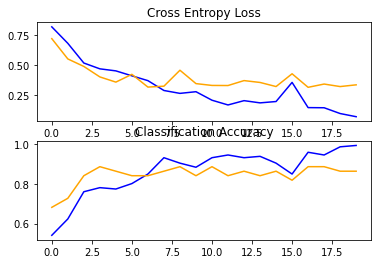


confusion matrix
[[9 5]
 [9 4]]


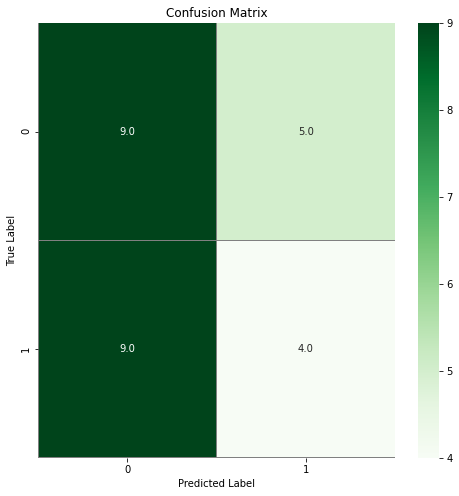

              precision    recall  f1-score   support

          ap       0.50      0.64      0.56        14
     lateral       0.44      0.31      0.36        13

    accuracy                           0.48        27
   macro avg       0.47      0.48      0.46        27
weighted avg       0.47      0.48      0.47        27



In [560]:
baseline_model = create_baseline_model(img_shape=img_shape)

_, _, _, _, _, _ = run_test(model=baseline_model, img_size=(img_shape[0], img_shape[1]), epochs=epochs)


## VGG model

- two-block vgg model
- three-block vgg model


In [561]:
def create_two_block_vgg_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



Found 146 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


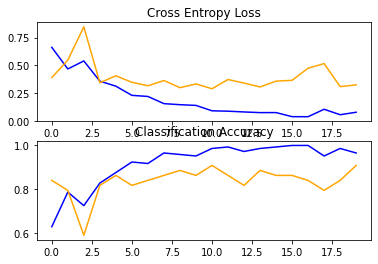


confusion matrix
[[11  3]
 [ 9  4]]


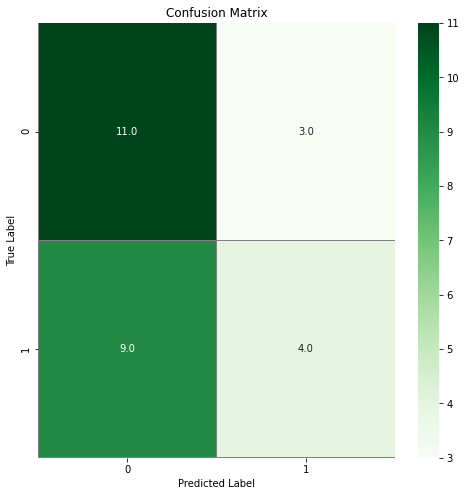

              precision    recall  f1-score   support

          ap       0.55      0.79      0.65        14
     lateral       0.57      0.31      0.40        13

    accuracy                           0.56        27
   macro avg       0.56      0.55      0.52        27
weighted avg       0.56      0.56      0.53        27



In [562]:
two_block_vgg_model = create_two_block_vgg_model(img_shape=img_shape)
_, _, _, _, _, _ = run_test(model=two_block_vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=epochs)



In [563]:
# define cnn model
def create_three_block_vgg_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 146 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


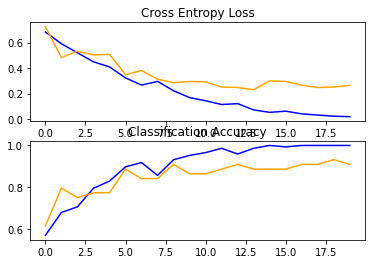


confusion matrix
[[10  4]
 [ 9  4]]


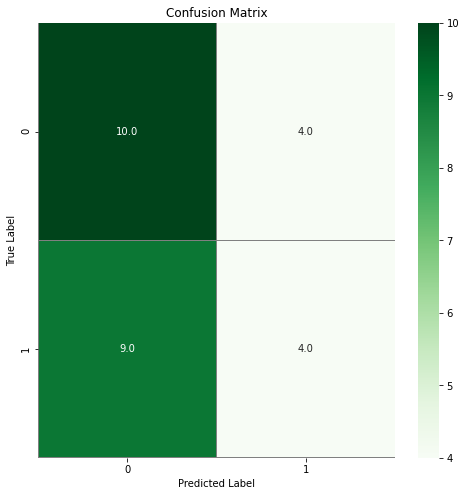

              precision    recall  f1-score   support

          ap       0.53      0.71      0.61        14
     lateral       0.50      0.31      0.38        13

    accuracy                           0.52        27
   macro avg       0.51      0.51      0.49        27
weighted avg       0.51      0.52      0.50        27



In [564]:
three_block_vgg_model = create_three_block_vgg_model(img_shape=img_shape)
_, _, _, _, _, _ = run_test(model=three_block_vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=epochs)



## Model Improvement



### Dropout Regularization

Dropout works by probabilistically removing inputs to a layer, 
which may be input variables in the data sample or activations from a previous layer. 

It has the effect of simulating a large number of networks with very different network structures and 
makes nodes in the network generally more robust to the inputs.


https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/


In [565]:
# define the cnn model

def create_vgg_model(img_shape=img_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 146 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


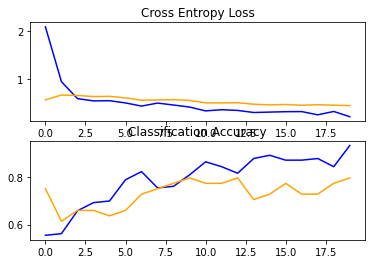


confusion matrix
[[11  3]
 [ 8  5]]


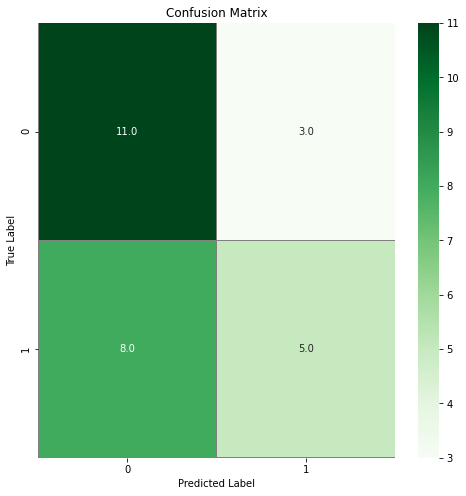

              precision    recall  f1-score   support

          ap       0.58      0.79      0.67        14
     lateral       0.62      0.38      0.48        13

    accuracy                           0.59        27
   macro avg       0.60      0.59      0.57        27
weighted avg       0.60      0.59      0.57        27



In [566]:
vgg_model = create_vgg_model(img_shape=img_shape)
_, _, _, _, _, _ = run_test(model=vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=epochs)


### Batch Normalization

https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/

https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/

https://www.machinecurve.com/index.php/2020/01/15/how-to-use-batch-normalization-with-keras/


"
Batch normalization is a technique for training very deep neural networks that standardizes the inputs 
to a layer for each mini-batch. 
This has the effect of stabilizing the learning process and dramatically reducing 
the number of training epochs required to train deep networks.
"


In [567]:
# define the cnn model

def create_vgg_model(img_shape=img_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 146 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


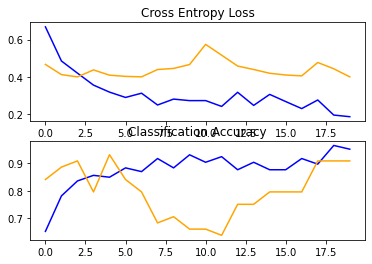


confusion matrix
[[12  2]
 [ 8  5]]


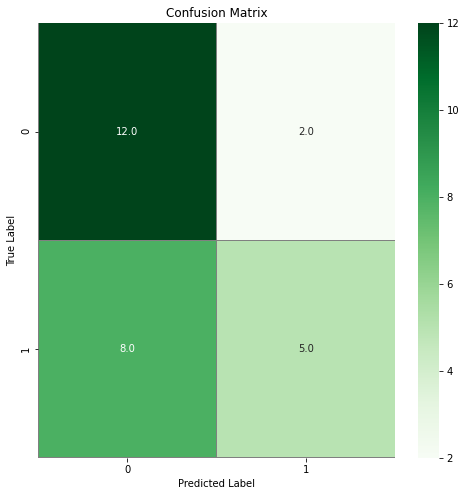

              precision    recall  f1-score   support

          ap       0.60      0.86      0.71        14
     lateral       0.71      0.38      0.50        13

    accuracy                           0.63        27
   macro avg       0.66      0.62      0.60        27
weighted avg       0.66      0.63      0.61        27



In [568]:
vgg_model = create_vgg_model(img_shape=img_shape)
_, _, _, _, _, _ = run_test(model=vgg_model, img_size=(img_shape[0], img_shape[1]), epochs=epochs)


### Data Augmentation


Found 146 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


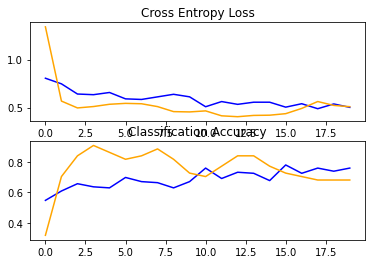


confusion matrix
[[13  1]
 [12  1]]


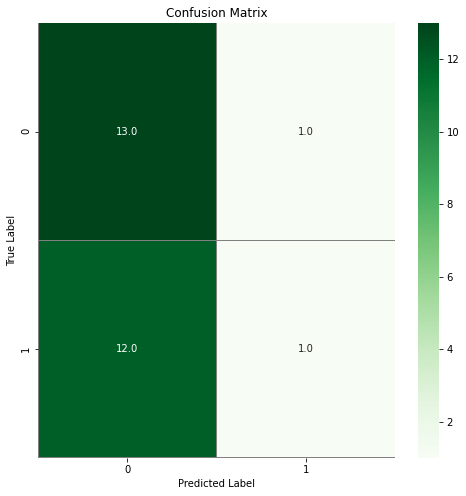

              precision    recall  f1-score   support

          ap       0.52      0.93      0.67        14
     lateral       0.50      0.08      0.13        13

    accuracy                           0.52        27
   macro avg       0.51      0.50      0.40        27
weighted avg       0.51      0.52      0.41        27



In [569]:
vgg_model = create_vgg_model(img_shape=img_shape)
_, _, _, train_generator, _, _ = run_test(model=vgg_model, 
                                          img_size=(img_shape[0], img_shape[1]), 
                                          epochs=epochs, 
                                          augment_data=True,
                                         )


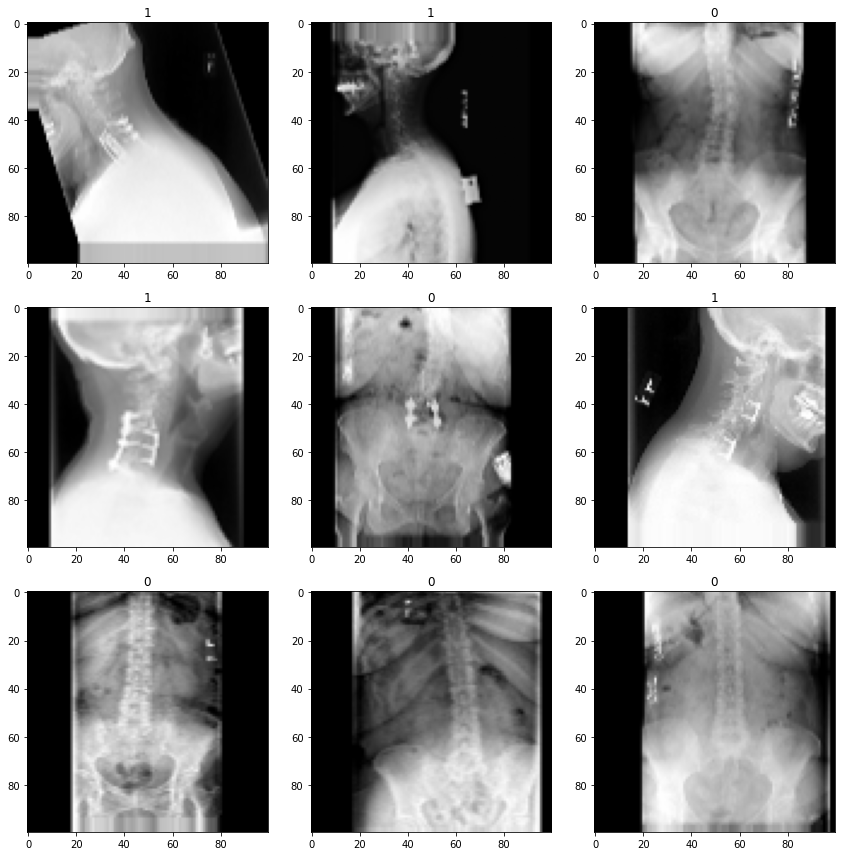

In [570]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.title(int(Y_batch[0]))
        break
plt.tight_layout()
plt.show()


### Balance the samples of each class in the training set


####  Downsampling 

In [571]:
def sample_images(src_directory, 
                  dataset_home, 
                  dst_dir_input, 
                  resize_img, 
                  val_ratio=0,
                  n_ap=83,
                  n_lateral=83,):
    
    files = listdir(src_directory)
    random.shuffle(files)
    
    if os.path.exists(dataset_home + dst_dir_input + 'ap/'):
        shutil.rmtree(dataset_home + dst_dir_input + 'ap/')
    makedirs(dataset_home + dst_dir_input + 'ap/', exist_ok=False)
    if os.path.exists(dataset_home + dst_dir_input + 'lateral/'):
        shutil.rmtree(dataset_home + dst_dir_input + 'lateral/')
    makedirs(dataset_home + dst_dir_input + 'lateral/', exist_ok=False)
    
    for file in files:
        src = src_directory + '/' + file
        
        dst_dir = dst_dir_input
        if val_ratio and random.random() < val_ratio:
            dst_dir = 'valid/'
        
        dst = ''
        if 'Lateral' in file and n_lateral > 0:
            dst = dataset_home + dst_dir + 'lateral/'  + file
            copyfile(src, dst)
            n_lateral -= 1
        elif 'AP' in file and n_ap:
            dst = dataset_home + dst_dir + 'ap/'  + file
            copyfile(src, dst)
            n_ap -= 1
        
        # resize image
        if n_lateral > 0 and n_ap > 0 and dst and resize_img:
            src = cv2.imread(dst, cv2.IMREAD_UNCHANGED)
            output = cv2.resize(src, resize_img)
            cv2.imwrite(dst, output)
            #with open(dst, 'r+b') as f:
            #    with Image.open(f) as image:
            #        cover = resizeimage.resize_cover(image, resize_img)
            #        cover.save(dst, image.format)
        
    return


In [572]:
"""
sample_images(train_folder, 
              dataset_home, 
              'train/', 
              resize_img, 
              val_ratio,
              n_ap = 83,
              n_lateral = 83,
             )

sample_images(train_folder, 
              dataset_home, 
              'final_train/', 
              resize_img, 
              val_ratio = 0,
              n_ap = 83,
              n_lateral = 83,
             )
"""

"\nsample_images(train_folder, \n              dataset_home, \n              'train/', \n              resize_img, \n              val_ratio,\n              n_ap = 83,\n              n_lateral = 83,\n             )\n\nsample_images(train_folder, \n              dataset_home, \n              'final_train/', \n              resize_img, \n              val_ratio = 0,\n              n_ap = 83,\n              n_lateral = 83,\n             )\n"

#### Upsampling 


In [573]:
def get_n_images(folder):
    n_images = 0
    for f in os.listdir(folder):
        if os.path.isfile(os.path.join(folder, f)):
            n_images += 1
    return n_images


In [574]:
n_upsample_ap_train_final = 20
n_upsample_ap_train = 20

n_train_ap = get_n_images(dataset_home + 'train/ap')
n_final_train_ap = get_n_images(dataset_home + 'final_train/ap')
   
n_train_lateral = get_n_images(dataset_home + 'train/lateral')
n_final_train_lateral = get_n_images(dataset_home + 'final_train/lateral')
   

n_upsample_lateral_train_final = n_upsample_ap_train_final + (n_final_train_ap - n_final_train_lateral) + 5
n_upsample_lateral_train = n_upsample_ap_train + (n_train_ap - n_train_lateral) + 5



In [575]:
# the following functions are adapted from
# https://gist.github.com/tomahim/9ef72befd43f5c106e592425453cb6ae

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)


def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)


def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]


def generate_images(folder_path, num_files_desired):
    # dictionary of the transformations we defined earlier
    available_transformations = {
        'rotate': random_rotation,
        'noise': random_noise,
        'horizontal_flip': horizontal_flip
    }

    # delete already generated images
    for f in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, f)) and 'augmented' in f:
            os.remove(os.path.join(folder_path, f))
            
    # find all files paths from the folder
    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
              if os.path.isfile(os.path.join(folder_path, f))]
    
    num_generated_files = 0
    while num_generated_files <= num_files_desired:
        # random image from the folder
        image_path = random.choice(images)
        # read image as an two dimensional array of pixels
        image_to_transform = sk.io.imread(image_path)
        # random num of transformation to apply
        num_transformations_to_apply = random.randint(1, len(available_transformations))

        num_transformations = 0
        transformed_image = None
        while num_transformations <= num_transformations_to_apply:
            # random transformation to apply for a single image
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](image_to_transform)
            num_transformations += 1
    

        new_file_path = '%s/augmented_image_%s.png' % (folder_path, num_generated_files)
        #print(new_file_path)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
        num_generated_files += 1
    
    return
  
    

In [577]:
# ap
folder_path = dataset_home + 'final_train/ap'
generate_images(folder_path=folder_path, 
                num_files_desired=n_upsample_ap_train_final)

folder_path = dataset_home + 'train/ap'
generate_images(folder_path=folder_path, 
                num_files_desired=n_upsample_ap_train)

# lateral
folder_path = dataset_home + 'final_train/lateral'
generate_images(folder_path=folder_path, 
                num_files_desired=n_upsample_lateral_train_final)

folder_path = dataset_home + 'train/lateral'
generate_images(folder_path=folder_path, 
                num_files_desired=n_upsample_lateral_train)



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

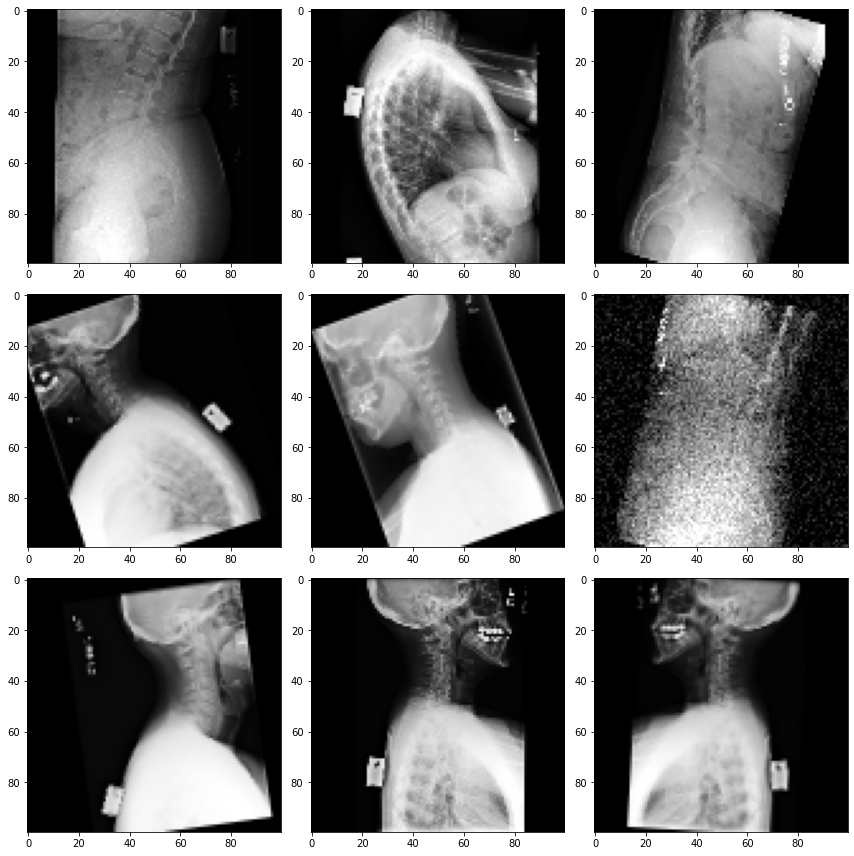

In [578]:
# plot some generated images

folder_path = dataset_home + 'final_train/lateral/'
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
              if os.path.isfile(os.path.join(folder_path, f)) and 'augmented' in f]

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = random.choice(images)
    image = load_img(image)
    plt.imshow(image)
        
plt.tight_layout()
plt.show()


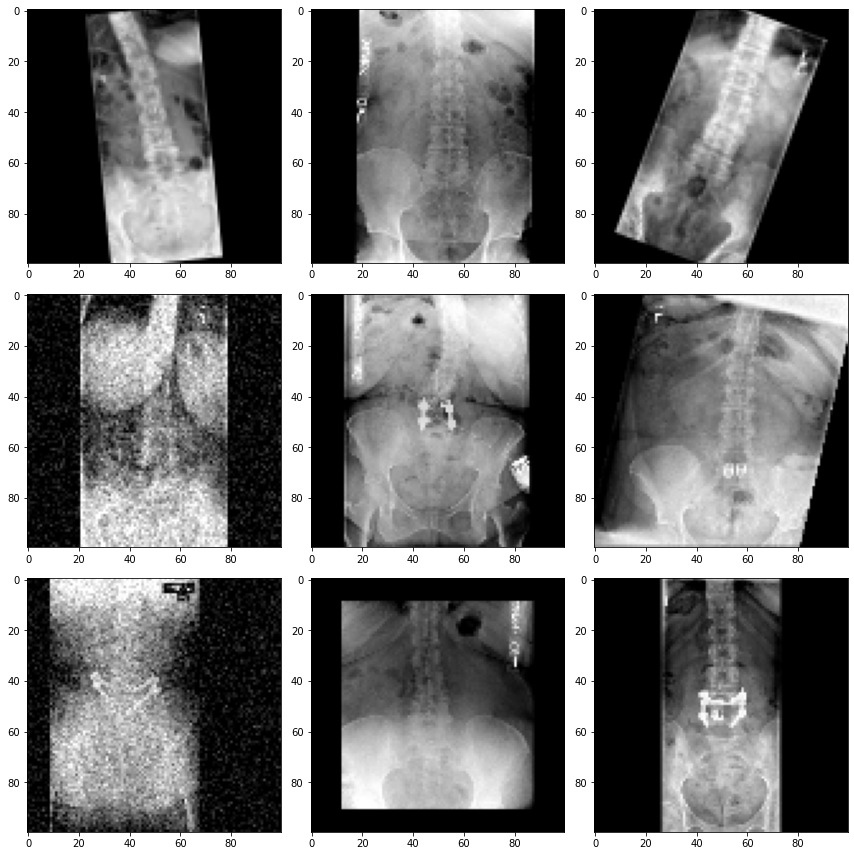

In [579]:

folder_path = dataset_home + 'final_train/ap/'
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
              if os.path.isfile(os.path.join(folder_path, f)) and 'augmented' in f]

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = random.choice(images)
    image = load_img(image)
    plt.imshow(image)
        
plt.tight_layout()
plt.show()


Found 203 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


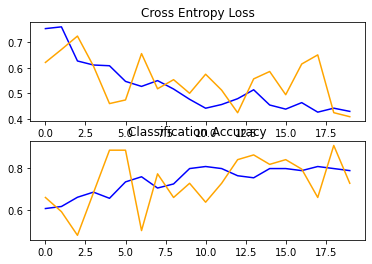


confusion matrix
[[13  1]
 [ 3 10]]


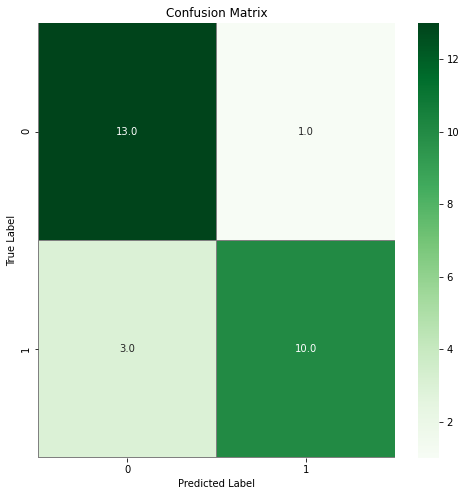

              precision    recall  f1-score   support

          ap       0.81      0.93      0.87        14
     lateral       0.91      0.77      0.83        13

    accuracy                           0.85        27
   macro avg       0.86      0.85      0.85        27
weighted avg       0.86      0.85      0.85        27



In [580]:
vgg_model = create_vgg_model(img_shape=img_shape)
_, _, _, train_generator, _, _ = run_test(model=vgg_model, 
                                          img_size=(img_shape[0], img_shape[1]), 
                                          epochs=epochs, 
                                          augment_data=True,
                                         )


## Transfer Learning


### VGG16

In [581]:

def create_vgg16_model(img_shape=(256, 256, 3)):
    model = VGG16(include_top=False, input_shape=img_shape)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    flat1 = BatchNormalization()(flat1)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    class1 = BatchNormalization()(class1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 203 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


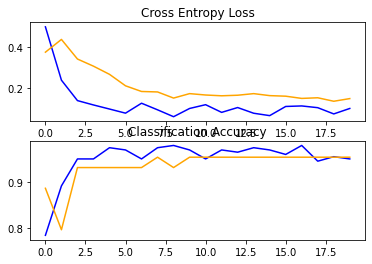


confusion matrix
[[14  0]
 [ 0 13]]


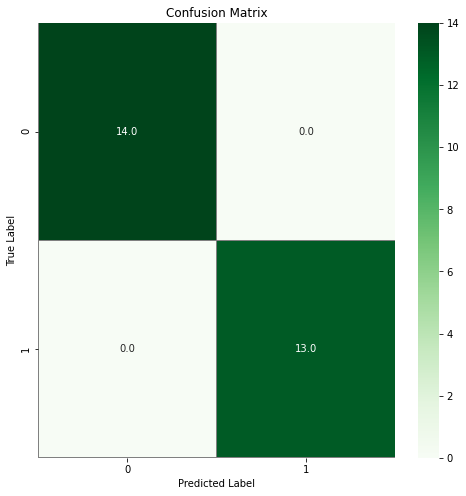

              precision    recall  f1-score   support

          ap       1.00      1.00      1.00        14
     lateral       1.00      1.00      1.00        13

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [582]:
vgg16_model = create_vgg16_model(img_shape=img_shape)
_, _, _, _, _, _ = run_test(model=vgg16_model, img_size=(img_shape[0], img_shape[1]), epochs=epochs, augment_data=True)


### ResNet50


In [583]:
def create_resnet50_model(img_shape=(256, 256, 3)):
    model = ResNet50(include_top=False, input_shape=img_shape)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    flat1 = BatchNormalization()(flat1)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    class1 = BatchNormalization()(class1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Found 203 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


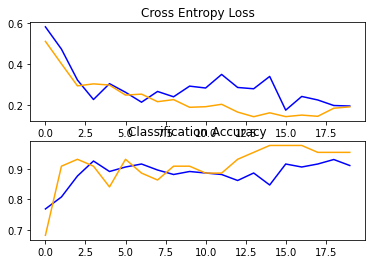


confusion matrix
[[14  0]
 [ 7  6]]


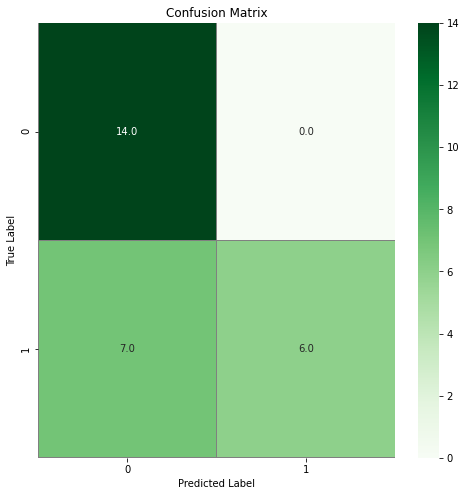

              precision    recall  f1-score   support

          ap       0.67      1.00      0.80        14
     lateral       1.00      0.46      0.63        13

    accuracy                           0.74        27
   macro avg       0.83      0.73      0.72        27
weighted avg       0.83      0.74      0.72        27



In [584]:
resnet50_model = create_resnet50_model(img_shape=img_shape)
_, _, _, _, _, _ = run_test(model=resnet50_model, img_size=(img_shape[0], img_shape[1]), epochs=epochs, augment_data=True)



### InceptionV3


In [585]:
def create_inceptionv3_model(img_shape=(256, 256, 3)):
    model = InceptionV3(include_top=False, input_shape=img_shape)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    flat1 = BatchNormalization()(flat1)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    class1 = BatchNormalization()(class1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



Found 203 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


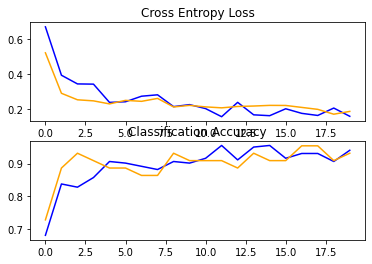


confusion matrix
[[14  0]
 [ 5  8]]


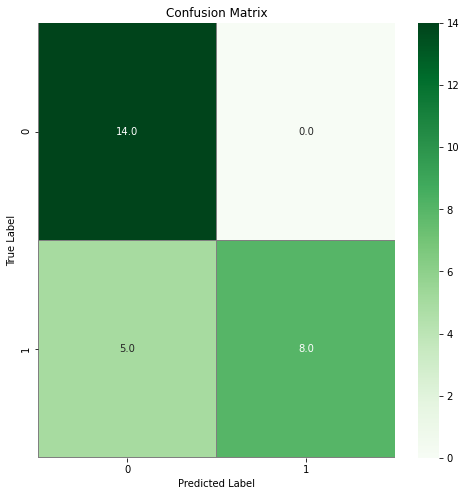

              precision    recall  f1-score   support

          ap       0.74      1.00      0.85        14
     lateral       1.00      0.62      0.76        13

    accuracy                           0.81        27
   macro avg       0.87      0.81      0.81        27
weighted avg       0.86      0.81      0.81        27



In [586]:
inceptionv3_model = create_inceptionv3_model(img_shape=img_shape)
_, _, _, _, _, _  = run_test(model=inceptionv3_model, img_size=(img_shape[0], img_shape[1]), epochs=epochs, augment_data=True)



# Results Evaluation


## Train and Save the Final Model


In [587]:
def train_vgg16_final(final_train_dir, img_shape=(128, 128, 3), epochs=10, batch_size=8):
    
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1, 
                                       horizontal_flip=True,
                                      )
            
    train_it = train_datagen.flow_from_directory(final_train_dir,
                                                 class_mode='binary', 
                                                 batch_size=batch_size, 
                                                 target_size=(img_shape[0], img_shape[1]),
                                                )


    vgg16_model = create_vgg16_model(img_shape=img_shape)
    
    vgg16_model.fit_generator(train_it, 
                              #validation_data=valid_it, 
                              #validation_steps=total_valid//batch_size,
                              #steps_per_epoch=total_train//batch_size,
                              epochs=epochs, 
                              verbose=0,
                             )
    
    vgg16_model.save('vgg16_model.h5')
    print('the final model is saved in vgg16_model.h5')
    
    return


def train_inceptionv3_final(final_train_dir, img_shape=(128, 128, 3), epochs=20, batch_size=8):
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1, 
                                       horizontal_flip=True,
                                      )

    train_it = train_datagen.flow_from_directory(final_train_dir,
                                                 class_mode='binary', 
                                                 batch_size=batch_size, 
                                                 target_size=(img_shape[0], img_shape[1]),
                                                )
    


    inceptionv3_model = create_inceptionv3_model(img_shape=img_shape)
    inceptionv3_model.fit_generator(train_it, epochs=epochs, verbose=0)

    inceptionv3_model.save('inceptionv3_model.h5')
    print('the final model is saved in inceptionv3_model.h5')
    
    return


In [588]:
train_vgg16_final('lateral_vs_ap/final_train', img_shape=img_shape, epochs=epochs)
#train_inceptionv3_final('lateral_vs_ap/final_train', img_shape=img_shape, epochs=epochs)


Found 261 images belonging to 2 classes.
the final model is saved in vgg16_model.h5


## Make the Prediction 


Found 27 images belonging to 2 classes.


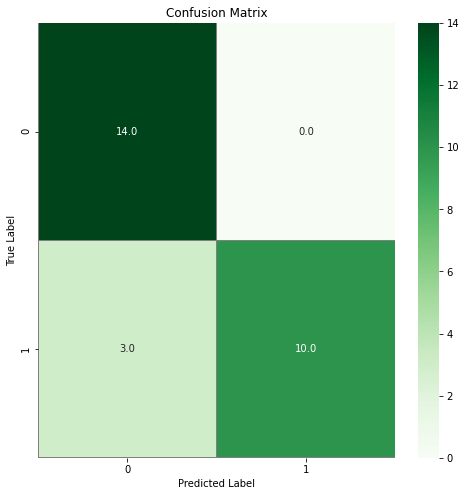

              precision    recall  f1-score   support

          ap       0.82      1.00      0.90        14
     lateral       1.00      0.77      0.87        13

    accuracy                           0.89        27
   macro avg       0.91      0.88      0.89        27
weighted avg       0.91      0.89      0.89        27



In [589]:
final_model = load_model('vgg16_model.h5')
#final_model = load_model('inceptionv3_model.h5')

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory('lateral_vs_ap/test/',
                                                  class_mode='binary', 
                                                  target_size=(img_shape[0], img_shape[1]),
                                                  shuffle=False,
                                                 )

preds = final_model.predict_generator(test_generator)

pred_labels = np.where(preds > 0.5, 1, 0)

pred_labels = [el[0] for el in pred_labels]

test_images, test_labels = test_generator.next()

confusion_matrix(test_labels, pred_labels)

plot_confusion_matrix(test_labels, pred_labels)

target_names = ['ap', 'lateral']
print(classification_report(test_labels, pred_labels, target_names=target_names))



# Troubleshooting


## Plot Misclassified Images

- class 0 -> ap
- class 1 -> lateral


In [590]:
for i in range(len(test_labels)):
    if test_labels[i] == 0 and test_labels[i] != pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        
    

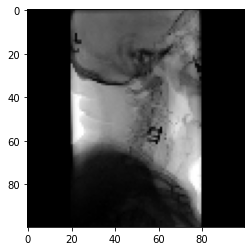

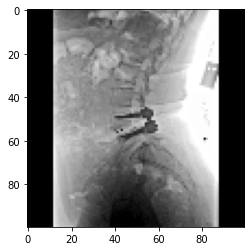

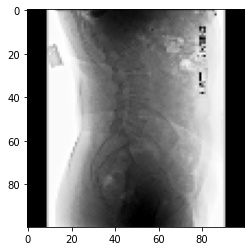

In [591]:
for i in range(len(test_labels)):
    if test_labels[i] == 1 and test_labels[i] != pred_labels[i]:
        image = test_images[i]
        plt.imshow(image)
        plt.show()
        

In [592]:
"""
def load_image(filename, img_size=(100, 100)):
    img = load_img(filename, target_size=img_size)
    img = img_to_array(img)
    img = img.reshape(1, img_size[0], img_size[1], 3)
    img = img.astype('float32')
    return img
 

def test_example(img_file):
    img = load_image(img_file)
    model = load_model('vgg16_model.h5')
    result = model.predict(img)
    print(result)
    return result[0][0]
    

print(test_example('../SnkeOS_MLENgineer_ChallengeData/Test/191_Lateral.png'))

"""

"\ndef load_image(filename, img_size=(100, 100)):\n    img = load_img(filename, target_size=img_size)\n    img = img_to_array(img)\n    img = img.reshape(1, img_size[0], img_size[1], 3)\n    img = img.astype('float32')\n    return img\n \n\ndef test_example(img_file):\n    img = load_image(img_file)\n    model = load_model('vgg16_model.h5')\n    result = model.predict(img)\n    print(result)\n    return result[0][0]\n    \n\nprint(test_example('../SnkeOS_MLENgineer_ChallengeData/Test/191_Lateral.png'))\n\n"

# Future Work


# Reference

* Collection! Deep learning must read 10 classic algorithm paper summary!

https://developpaper.com/collection-deep-learning-must-read-10-classic-algorithm-paper-summary/


* How to Classify Photos of Dogs and Cats (with 97% accuracy)

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/



* Convolutional Neural Networks, Coursera, deeplearning.ai

https://www.coursera.org/learn/convolutional-neural-networks


* Deep Learning vs. Traditional Computer Vision

https://arxiv.org/pdf/1910.13796.pdf


* Image Classification

https://paperswithcode.com/task/image-classification



* Building powerful image classification models using very little data

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


* Dog vs Cat, kaggle competition

https://www.kaggle.com/c/dogs-vs-cats


* N-Shot Learning: Learning More with Less Data

https://blog.floydhub.com/n-shot-learning/


* Transfer Learning in Keras with Computer Vision Models

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/


* Is deep learning applicable for small data sets of 200 images in image classification?

https://www.quora.com/Is-deep-learning-applicable-for-small-data-sets-of-200-images-in-image-classification


* Cricket or baseball? Lesson 1 with small datasets

https://forums.fast.ai/t/cricket-or-baseball-lesson-1-with-small-datasets/8097


* fast.ai computer vision

https://docs.fast.ai/tutorial.vision

